In the first course in this step, Machine Learning Fundamentals, we walked through the full machine learning workflow using the k-nearest neighbors algorithm. K-nearest neighbors works by finding similar, labelled examples from the training set for each instance in the test set and uses them to predict the label. K-nearest neighbors is known as an instance-based learning algorithm because it relies completely on previous instances to make predictions. The k-nearest neighbors algorithm doesn't try to understand or capture the relationship between the feature columns and the target column.

Because the entire training dataset is used to find a new instance's nearest neighbors to make label predictions, this algorithm doesn't scale well to medium and larger datasets. If we have a million instances in our training data set and we want to make predictions for a hundred thousand new instances, we'd have to sort the million instances in the training set by Euclidean distance for each instance.

# Model Based Learning

To get familiar with this machine learning approach, we'll work with a dataset on sold houses in Ames, Iowa. Each row in the dataset describes the properties of a single house as well as the amount it was sold for. In this course, we'll build models that predict the final sale price from its other attributes. Specifically, we'll explore the following questions:

 - Which properties of a house most affect the final sale price?
 
 - How effectively can we predict the sale price from just its properties?

This dataset was originally compiled by [Dean De Cock](http://www.truman.edu/faculty-staff/decock/) for the primary purpose of having a high quality dataset for regression. You can read more about his process and motivation [here](https://doi.org/10.1080/10691898.2011.11889627) and download the dataset [here](https://dsserver-prod-resources-1.s3.amazonaws.com/235/AmesHousing.txt). There is also a data dictionary [here](http://www.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt).

Here are some of the columns:

 - `Lot Area`: Lot size in square feet.
 
 - `Overall Qual`: Rates the overall material and finish of the house.
 
 - `Overall Cond`: Rates the overall condition of the house.
 
 - `Year Built`: Original construction date.
 
 - `Low Qual Fin SF`: Low quality finished square feet (all floors).
 
 - `Full Bath`: Full bathrooms above grade.
 
 - `Fireplaces`: Number of fireplaces.
 

Let's start by generating `train` and `test` datasets and getting more familiar with the data.

In [1]:
import pandas as pd
data = pd.read_csv('AmesHousing.txt', delimiter="\t")
train = data[0:1460]
test = data[1460:]

print(train.info())
target = 'SalePrice'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
Order              1460 non-null int64
PID                1460 non-null int64
MS SubClass        1460 non-null int64
MS Zoning          1460 non-null object
Lot Frontage       1211 non-null float64
Lot Area           1460 non-null int64
Street             1460 non-null object
Alley              109 non-null object
Lot Shape          1460 non-null object
Land Contour       1460 non-null object
Utilities          1460 non-null object
Lot Config         1460 non-null object
Land Slope         1460 non-null object
Neighborhood       1460 non-null object
Condition 1        1460 non-null object
Condition 2        1460 non-null object
Bldg Type          1460 non-null object
House Style        1460 non-null object
Overall Qual       1460 non-null int64
Overall Cond       1460 non-null int64
Year Built         1460 non-null int64
Year Remod/Add     1460 non-null int64
Roof Style         14

We'll start by understanding the univariate case of linear regression, also known as simple linear regression. The following equation is the general form of the simple linear regression model.

${^y} = a_1x_1 + a_0$


${^y}$ represents the target column while $x_1$ represents the feature column we choose to use in our model. These values are independent of the dataset. On the other hand, $a_1$ and $a_0$ represent the parameter values that are specific to the dataset. 

The goal of simple linear regression is to find the optimal parameter values that best describe the relationship between the feature column and the target column.

Steps:

 - Create a figure with dimensions 7 x 15 containing three scatter plots in a single column:

   - The first plot should plot the `Garage Area` column on the x-axis against the `SalePrice` column on the y-axis.
  
   - The second one should plot the `Gr Liv Area` column on the x-axis against the `SalePrice` column on the y-axis.

   - The third one should plot the `Overall Cond` column on the x-axis against the `SalePrice` column on the y-axis.

From the data dictionary mentioned above:

 - `Garage Area` (Continuous): Size of garage in square feet
 
 - `Gr Liv Area` (Continuous): Above grade (ground) living area square feet
 
 - `Overall Cond` (Ordinal): Rates the overall condition of the house on a scale of 1 to 10 with 10 being the best
 
Also we find the following note:
 
#### Potential Pitfalls (Outliers): Although all known errors were corrected in the data, no observations have been removed due to unusual values and all final residential sales from the initial data set are included in the data presented with this article. There are five observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these points). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these five unusual observations) before assigning it to students.

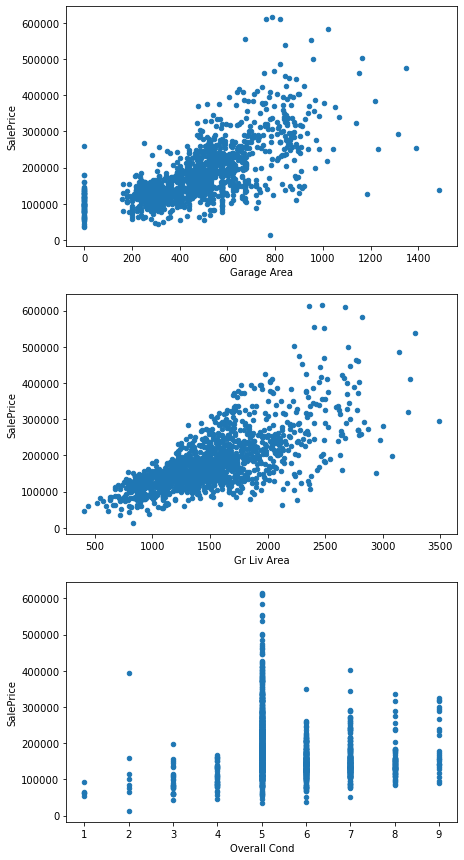

In [2]:
import matplotlib.pyplot as plt
# For prettier plots.
import seaborn
fig = plt.figure(figsize=(7,15))

ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

train.plot(x="Garage Area", y="SalePrice", ax=ax1, kind="scatter")
train.plot(x="Gr Liv Area", y="SalePrice", ax=ax2, kind="scatter")
train.plot(x="Overall Cond", y="SalePrice", ax=ax3, kind="scatter")

plt.show()

We can tell that the `Gr Liv Area` feature correlates the most with the `SalePrice` column. We can confirm this by calculating the correlation between pairs of these columns using the `pandas.DataFrame.corr()` method:

In [3]:
print(train[['Garage Area', 'Gr Liv Area', 'Overall Cond', 'SalePrice']].corr())

              Garage Area  Gr Liv Area  Overall Cond  SalePrice
Garage Area      1.000000     0.465366     -0.132401   0.662397
Gr Liv Area      0.465366     1.000000     -0.133710   0.698990
Overall Cond    -0.132401    -0.133710      1.000000  -0.099395
SalePrice        0.662397     0.698990     -0.099395   1.000000


The correlation between Gr Liv Area and SalePrice is around 0.709, which is the highest. Recall that the closer the correlation coefficient is to 1.0, the stronger the correlation.

#### Residual Sum Of Squares - Least Squares

To find the optimal parameters for a linear regression model, we want to optimize the model's residual sum of squares (or RSS). If you recall, residual (often referred to as errors) describes the difference between the predicted values for the target column (\hat{y}) and the true values (y).

We want this difference to be as small as possible. Calculating RSS involves summing the squared errors.

If you recall, the calculation for RSS _seems_ very similar to the calculation for MSE (mean squared error)

Let's now use `scikit-learn` to find the optimal parameter values for our model. The scikit-learn library was designed to easily swap and try different models. Because we're familiar with the scikit-learn workflow for k-nearest neighbors, switching to using linear regression is straightforward.

Instead of working with the `sklearn.neighbors.KNeighborsRegressors` class, we work with the `sklearn.linear_model.LinearRegression` class. The LinearRegression class also has it's own `fit()` method. Specific to this model, however, are the `coef_` and `intercept_` attributes, which return $a1$ 
 ($a1$ to $an$ if it were a multivariate regression model) and $a0$ accordingly.
 
Steps:
 
 - Import and instantiate a linear regression model.
 - Fit a linear regression model that uses the feature and target columns we explored in the last 2 screens. Use the default arguments.
 - Display the coefficient and intercept of the fitted model using the `coef_` and `intercept_` attributes.
 - Assign $a1$ to a1 and $a0$ to a0.

In [4]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train[['Gr Liv Area']], train['SalePrice'])
print(lr.coef_)
print(lr.intercept_)

a0 = lr.intercept_
a1 = lr.coef_

[116.86624683]
5366.821710056043


In the last step, we fit a univariate linear regression model between the Gr Liv Area and SalePrice columns. We then displayed the single coefficient and the residual value. If we refer back to the format of our linear regression model, the fitted model can be represented as:

$y^ = 116.86624683$x1$ + 5366.821710056043$

One way to interpret this model is "for every 1 square foot increase in above ground living area, we can expect the home's value to increase by approximately 116.87 dollars".

We can now use the `predict()` method to predict the labels using the training data and compare them with the actual labels. To quantify the fit, we can use `mean squared error`. Let's also perform simple validation by making predictions on the test set and calculate the MSE value for those predictions as well.

Steps:

 - Use the fitted model to make predictions on both the training and test sets.
 
 - Calculate the `RMSE` value for the predictions on the training set and assign to `train_rmse`.
 
 - Calculate the `RMSE` value for the predictions on the test set and assign to `test_rmse`.

In [5]:
import numpy as np

lr = LinearRegression()
lr.fit(train[['Gr Liv Area']], train['SalePrice'])
from sklearn.metrics import mean_squared_error

train_predictions = lr.predict(train[['Gr Liv Area']])
test_predictions = lr.predict(test[['Gr Liv Area']])

train_mse = mean_squared_error(train_predictions, train['SalePrice'])
test_mse = mean_squared_error(test_predictions, test['SalePrice'])

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(train_rmse)
print(test_rmse)

56034.362001412796
57088.25161263909


### Multiple Linear Regression

Now that we've explored the basics of simple linear regression, we can extend what we've learned to the multivariate case (often called multiple linear regression). A multiple linear regression model allows us to capture the relationship between multiple feature columns and the target column.

When using multiple features, the main challenge is selecting relevant features. In a later mission in this course, we'll dive into some approaches for feature selection. For now, let's train a model using the following columns from the dataset to see how train and test RMSE values are improved.

 - `Overall Cond`
 - `Gr Liv Area`
 
 Steps:
 
 - Train a linear regression model using the columns in `cols`.

 - Use the fitted model to make predictions on both the training and test dataset.

 - Calculate the RMSE value for the predictions on the training set and assign to `train_rmse_2`.
 
 - Calculate the RMSE value for the predictions on the test set and assign to `test_rmse_2`.

In [6]:
cols = ['Overall Cond', 'Gr Liv Area']
lr.fit(train[cols], train['SalePrice'])
train_predictions = lr.predict(train[cols])
test_predictions = lr.predict(test[cols])

train_rmse_2 = np.sqrt(mean_squared_error(train_predictions, train['SalePrice']))
test_rmse_2 = np.sqrt(mean_squared_error(test_predictions, test['SalePrice']))

print(train_rmse_2)
print(test_rmse_2)

56032.39801525867
57066.90779448559


## Missing Values 

In the machine learning workflow, once we've selected the model we want to use, selecting the appropriate features for that model is the next important step. In this mission, we'll explore how to use correlation between features and the target column, correlation between features, and variance of features to select features. We'll continue working with the same housing dataset from the last mission.

We'll specifically focus on selecting from feature columns that don't have any missing values or don't need to be transformed to be useful (e.g. columns like `Year Built` and `Year Remod/Add`). We'll explore how to deal with both of these in a later mission in this course.

To start, let's look at which columns fall into either of these two categories.

In [7]:
numerical_train = train.select_dtypes(include=['int', 'float'])
numerical_train = numerical_train.drop(['PID', 'Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Mo Sold', 'Yr Sold'], axis=1)
null_series = numerical_train.isnull().sum()
full_cols_series = null_series[null_series == 0]
print(full_cols_series)

Order              0
MS SubClass        0
Lot Area           0
Overall Qual       0
Overall Cond       0
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
Gr Liv Area        0
Full Bath          0
Half Bath          0
Bedroom AbvGr      0
Kitchen AbvGr      0
TotRms AbvGrd      0
Fireplaces         0
Garage Cars        0
Garage Area        0
Wood Deck SF       0
Open Porch SF      0
Enclosed Porch     0
3Ssn Porch         0
Screen Porch       0
Pool Area          0
Misc Val           0
SalePrice          0
dtype: int64


In [8]:
len(full_cols_series)

25

In [9]:
# Correlating Feature cols with Target cols

train_subset = train[full_cols_series.index]
corrmat = train_subset.corr()
sorted_corrs = corrmat['SalePrice'].abs().sort_values()
print(sorted_corrs)

Misc Val           0.009903
3Ssn Porch         0.038699
Low Qual Fin SF    0.060352
Order              0.068181
MS SubClass        0.088504
Overall Cond       0.099395
Screen Porch       0.100121
Bedroom AbvGr      0.106941
Kitchen AbvGr      0.130843
Pool Area          0.145474
Enclosed Porch     0.165873
2nd Flr SF         0.202352
Half Bath          0.272870
Lot Area           0.274730
Wood Deck SF       0.319104
Open Porch SF      0.344383
TotRms AbvGrd      0.483701
Fireplaces         0.485683
Full Bath          0.518194
1st Flr SF         0.657119
Garage Area        0.662397
Garage Cars        0.663485
Gr Liv Area        0.698990
Overall Qual       0.804562
SalePrice          1.000000
Name: SalePrice, dtype: float64


## Visualization - Correlation Matrix Heatmap

We now have a decent list of candidate features to use in our model, sorted by how strongly they're correlated with the `SalePrice` column. For now, let's keep only the features that have a correlation of `0.3` or higher. This cutoff is a bit arbitrary and, in general, it's a good idea to experiment with this cutoff. For example, you can train and test models using different cutoffs and see where your model stops improving.

The next thing we need to look for is for potential collinearity between some of these feature columns. Collinearity is when 2 feature columns are highly correlated and stand the risk of duplicating information. If we have 2 features that convey the same information using 2 different measures or metrics, we don't need to keep both.

While we can check for collinearity between 2 columns using the correlation matrix, we run the risk of information overload. We can instead generate a correlation matrix heatmap using Seaborn to visually compare the correlations and look for problematic pairwise feature correlations. Because we're looking for outlier values in the heatmap, this visual representation is easier

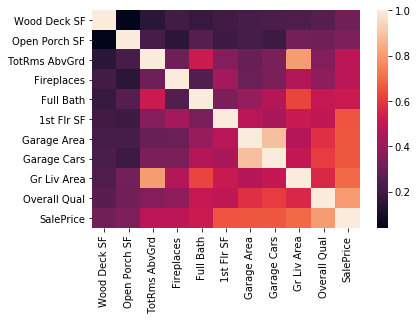

In [11]:
import seaborn as sns
strong_corrs = sorted_corrs[sorted_corrs > 0.3]

corrmat = train_subset[strong_corrs.index].corr()

sns.heatmap(corrmat)

### Train and Test Model

Based on the correlation matrix heatmap, we can tell that the following pairs of columns are strongly correlated:

 - `Gr Liv Area` and `TotRms AbvGrd`
 - `Garage Area` and `Garage Cars`
 
If we read the descriptions of these columns from the data documentation, we can tell that each pair of columns reflects very similar information. Because `Gr Liv Area` and `Garage Area` are continuous variables that capture more nuance, let's drop the `TotRms AbvGrd` and `Garage Cars`.

Steps:

 - Filter the test data frame so it only contains the columns from `final_corr_cols.index`. Then, drop the row containing missing values and assign the result to clean_test
 - Build a linear regression model using the features in features.
 - Calculate the RMSE on the test and train sets.
 - Assign the train RMSE to `train_rmse` and the test RMSE to `test_rmse`.

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np


final_corr_cols = strong_corrs.drop(['Garage Cars', 'TotRms AbvGrd'])
features = final_corr_cols.drop(['SalePrice']).index
target = 'SalePrice'
clean_test = test[final_corr_cols.index].dropna()

lr = LinearRegression()
lr.fit(train[features], train['SalePrice'])

train_predictions = lr.predict(train[features])
test_predictions = lr.predict(clean_test[features])

train_mse = mean_squared_error(train_predictions, train[target])
test_mse = mean_squared_error(test_predictions, clean_test[target])

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(train_rmse)
print(test_rmse)

34173.97629185851
41032.026120197705


### Removing Low Variance Features

The last technique we'll explore is removing features with low variance. When the values in a feature column have low variance, they don't meaningfully contribute to the model's predictive capability. On the extreme end, let's imagine a column with a variance of `0`. This would mean that all of the values in that column were exactly the same. This means that the column isn't informative and isn't going to help the model make better predictions.

To make apples to apples comparisons between columns, we need to rescale all of the columns to vary between `0` and `1`. Then, we can set a cutoff value for variance and remove features that have less than that variance amount. This is known as min-max scaling or as rescaling.

Steps:

- Select the columns in features from the train data frame. Rescale each of the columns so the values range from `0` to `1`, by using `train[features]` instead of 
in the formula above. Assign the result to `unit_train`.

- Calculate and display the column minimum and maximum values of `unit_train` to ensure that all values range from 0 to 1.

- Use the `DataFrame.var` method to compute the variance of these columns, sort the resulting series by its values, and assign to `sorted_vars`.

- Print `sorted_vars`.

In [13]:
unit_train = (train[features] - train[features].min())/(train[features].max() - train[features].min())
print(unit_train.min())
print(unit_train.max())
# Confirmed: the min and max values are 0.0 and 1.0 respectively

sorted_vars = unit_train.var().sort_values()
print(sorted_vars)

Wood Deck SF     0.0
Open Porch SF    0.0
Fireplaces       0.0
Full Bath        0.0
1st Flr SF       0.0
Garage Area      0.0
Gr Liv Area      0.0
Overall Qual     0.0
dtype: float64
Wood Deck SF     1.0
Open Porch SF    1.0
Fireplaces       1.0
Full Bath        1.0
1st Flr SF       1.0
Garage Area      1.0
Gr Liv Area      1.0
Overall Qual     1.0
dtype: float64
Open Porch SF    0.013938
Full Bath        0.018621
Garage Area      0.020347
Gr Liv Area      0.023078
Overall Qual     0.024496
1st Flr SF       0.025814
Wood Deck SF     0.033064
Fireplaces       0.046589
dtype: float64


### Final Model

Let's set a cutoff variance of 0.015, remove the Open Porch SF feature, and train and test a model using the remaining features.



In [14]:
clean_test = test[final_corr_cols.index].dropna()
features = features.drop('Open Porch SF')

lr = LinearRegression()
lr.fit(train[features], train['SalePrice'])

train_predictions = lr.predict(train[features])
test_predictions = lr.predict(clean_test[features])

train_mse = mean_squared_error(train_predictions, train[target])
test_mse = mean_squared_error(test_predictions, clean_test[target])

train_rmse_2 = np.sqrt(train_mse)
test_rmse_2 = np.sqrt(test_mse)

print(train_rmse_2)
print(test_rmse_2)

34372.696707783965
40591.42702437715


We were able to improve the RMSE value to approximately 40591 by removing the Open Porch SF feature. 

This is most likely the furthest we can go without transforming and utilizing the other features in the dataset so we'll stop here for now. 

In the next 2 missions, we'll explore 2 different ways of fitting models. Afterwards, we'll explore ways to clean and engineer new features from the existing features to improve model accuracy even further.

### Gradient Descent

The gradient descent algorithm works by iteratively trying different parameter values until the model with the lowest mean squared error is found. Gradient descent is a commonly used optimization technique for other models as well, like neural networks.

A function that we optimize through minimization is known as a cost function or sometimes as the loss function.


In [16]:
# Derivative of the cost function

def derivative(a1, xi_list, yi_list):
    len_data = len(xi_list)
    error = 0
    for i in range(0, len_data):
        error += xi_list[i]*(a1*xi_list[i] - yi_list[i])
    deriv = 2*error/len_data
    return deriv

def gradient_descent(xi_list, yi_list, max_iterations, alpha, a1_initial):
    a1_list = [a1_initial]

    for i in range(0, max_iterations):
        a1 = a1_list[i]
        deriv = derivative(a1, xi_list, yi_list)
        a1_new = a1 - alpha*deriv
        a1_list.append(a1_new)
    return(a1_list)


param_iterations = gradient_descent(train['Gr Liv Area'], train['SalePrice'], 20, .0000003, 150)
final_param = param_iterations[-1]

print(param_iterations, final_param)

[150, 106.24258269493151, 126.61281661731272, 117.12993450021699, 121.54446668425497, 119.48938531096931, 120.44607998998796, 120.00071333893449, 120.20804328256295, 120.11152571569237, 120.15645719327628, 120.13554040327286, 120.1452777216869, 120.14074474268385, 120.14285496418101, 120.14187260031741, 120.14232991665213, 120.142117023815, 120.14221613105579, 120.14216999401657, 120.14219147202738] 120.14219147202738


In [17]:
# Gradient of the cost function

def a1_derivative(a0, a1, xi_list, yi_list):
    len_data = len(xi_list)
    error = 0
    for i in range(0, len_data):
        error += xi_list[i]*(a0 + a1*xi_list[i] - yi_list[i])
    deriv = 2*error/len_data
    return deriv

def a0_derivative(a0, a1, xi_list, yi_list):
    len_data = len(xi_list)
    error = 0
    for i in range(0, len_data):
        error += a0 + a1*xi_list[i] - yi_list[i]
    deriv = 2*error/len_data
    return deriv

def gradient_descent(xi_list, yi_list, max_iterations, alpha, a1_initial, a0_initial):
    a1_list = [a1_initial]
    a0_list = [a0_initial]

    for i in range(0, max_iterations):
        a1 = a1_list[i]
        a0 = a0_list[i]
        
        a1_deriv = a1_derivative(a0, a1, xi_list, yi_list)
        a0_deriv = a0_derivative(a0, a1, xi_list, yi_list)
        
        a1_new = a1 - alpha*a1_deriv
        a0_new = a0 - alpha*a0_deriv
        
        a1_list.append(a1_new)
        a0_list.append(a0_new)
    return(a0_list, a1_list)

a0_params, a1_params = gradient_descent(train['Gr Liv Area'], train['SalePrice'], 20, .0000003, 150, 1000)

print(a0_params, a1_params)

[1000, 999.9729797812329, 999.985903701066, 999.980232547139, 999.9832179015052, 999.9821734177915, 999.983004932363, 999.9829631191217, 999.9833278635107, 999.98350334434, 999.9837669324418, 999.9839895042135, 999.9842311701743, 999.9844639472566, 999.9847008623329, 999.9849358510428, 999.9851717365096, 999.9854072044933, 999.985642866808, 999.9858784386378, 999.986114052572] [150, 105.34801721547944, 126.13471917628125, 116.45794862200977, 120.96274606972909, 118.86564116059868, 119.84189984026605, 119.38742488614261, 119.59899502291616, 119.50050320781361, 119.54635359313434, 119.52500879150305, 119.53494516153384, 119.53031930255781, 119.53247255390217, 119.53146994657168, 119.53193647656232, 119.53171908350993, 119.53182007507831, 119.53177285001942, 119.53179462379771]


### Ordinary Least Squares - OLS 

scikit-learn uses OLS under the hood when you call fit() on a LinearRegression instance

 - Select just the features in features from the training set and assign to `X`.
 - Select the SalePrice column from the training set and assign to `y`.
  - Use the OLS estimation formula to return the optimal parameter values. Store the estimation to the variable `ols_estimation`

In [18]:
data = pd.read_csv('AmesHousing.txt', delimiter="\t")
train = data[0:1460]
test = data[1460:]

features = ['Wood Deck SF', 'Fireplaces', 'Full Bath', '1st Flr SF', 'Garage Area',
       'Gr Liv Area', 'Overall Qual']

X = train[features]
y = train['SalePrice']

first_term = np.linalg.inv(
        np.dot(
            np.transpose(X), 
            X
        )
    )
second_term = np.dot(
        np.transpose(X),
        y
    )
ols_estimation = np.dot(first_term, second_term)
print(ols_estimation)

[   53.75693376 18232.31375751 -6434.65300989    22.53151963
    86.81522574    28.08976713 11397.64135314]


Unlike gradient descent, OLS estimation provides what is known as a closed form solution to the problem of finding the optimal parameter values. A closed form solution is one where a solution can be computed arithmetically with a predictable amount of mathematical operations. Gradient descent, on the other hand, is an algorithmic approach that can require a different number of iterations (and therefore a different number of mathematical operations) based on the initial parameter values, the learning rate, etc. While the approach is different, both techniques share the high level objective of minimizing the cost function.

The biggest limitation is that OLS estimation is computationally expensive when the data is large. This is because computing a matrix inverse has a computational complexity of approximately O(n^3).

OLS is commonly used when the number of elements in the dataset (and therefore the matrix that's inverted) is less than a few million elements. 

On larger datasets, gradient descent is used because it's much more flexible. 

For many practical problems, we can set a threshold accuracy value (or a set number of iterations) and use a "good enough" solution. This is especially useful when iterating and trying different features in our model.

### Processing and Transforming Features

To understand how linear regression works, we've stuck to using features from the training dataset that contained no missing values and were already in a convenient numeric representation. In this mission, we'll explore how to transform some of the remaining features so we can use them in our model. Broadly, the process of processing and creating new features is known as feature engineering. Feature engineering is a bit of an art and having knowledge in the specific domain (in this case real estate) can help you create better features. In this mission, we'll focus on some domain-independent strategies that work for all problems.

In the first half of this mission, we'll focus only on columns that contain no missing values but still aren't in the proper format to use in a linear regression model. In the latter half of this mission, we'll explore some ways to deal with missing values.

In [19]:
data = pd.read_csv('AmesHousing.txt', delimiter="\t")
train = data[0:1460]
test = data[1460:]

train_null_counts = train.isnull().sum()
print(train_null_counts)

# data frame no missing values
df_no_mv = train[train_null_counts[train_null_counts==0].index]

Order               0
PID                 0
MS SubClass         0
MS Zoning           0
Lot Frontage      249
                 ... 
Mo Sold             0
Yr Sold             0
Sale Type           0
Sale Condition      0
SalePrice           0
Length: 82, dtype: int64


In [20]:
df_no_mv.head

<bound method NDFrame.head of       Order        PID  MS SubClass MS Zoning  Lot Area Street Lot Shape  \
0         1  526301100           20        RL     31770   Pave       IR1   
1         2  526350040           20        RH     11622   Pave       Reg   
2         3  526351010           20        RL     14267   Pave       IR1   
3         4  526353030           20        RL     11160   Pave       Reg   
4         5  527105010           60        RL     13830   Pave       IR1   
...     ...        ...          ...       ...       ...    ...       ...   
1455   1456  907253060           60        RL     10316   Pave       IR1   
1456   1457  907253110           60        RL     10400   Pave       Reg   
1457   1458  907254020           60        RL      9066   Pave       IR1   
1458   1459  907254090           60        RL     11404   Pave       IR1   
1459   1460  907255020           60        RL      9240   Pave       Reg   

     Land Contour Utilities Lot Config  ... Enclosed Porc

### Categorical features

You'll notice that some of the columns in the data frame df_no_mv contain string values. If these columns contain only a limited set of uniuqe values, they're known as categorical features.



In [21]:
print(train['Utilities'].value_counts())

AllPub    1457
NoSewr       2
NoSeWa       1
Name: Utilities, dtype: int64


In [22]:
print(train['Street'].value_counts())

Pave    1455
Grvl       5
Name: Street, dtype: int64


In [23]:
print(train['House Style'].value_counts())

1Story    743
2Story    440
1.5Fin    160
SLvl       60
SFoyer     35
2.5Unf     11
1.5Unf      8
2.5Fin      3
Name: House Style, dtype: int64


To use these features in our model, we need to transform them into numerical representations. 

Thankfully, pandas makes this easy because the library has a special categorical data type. 

We can convert any column that contains no missing values (or an error will be thrown) to the categorical data type using the `pandas.Series.astype()` method

In [24]:
text_cols = df_no_mv.select_dtypes(include=['object']).columns

for col in text_cols:
    print(col+":", len(train[col].unique()))
for col in text_cols:
    train[col] = train[col].astype('category')
train['Utilities'].cat.codes.value_counts()

MS Zoning: 6
Street: 2
Lot Shape: 4
Land Contour: 4
Utilities: 3
Lot Config: 5
Land Slope: 3
Neighborhood: 26
Condition 1: 9
Condition 2: 6
Bldg Type: 5
House Style: 8
Roof Style: 6
Roof Matl: 5
Exterior 1st: 14
Exterior 2nd: 16
Exter Qual: 4
Exter Cond: 5
Foundation: 6
Heating: 6
Heating QC: 4
Central Air: 2
Electrical: 4
Kitchen Qual: 5
Functional: 7
Paved Drive: 3
Sale Type: 9
Sale Condition: 5


/Users/otto/opt/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    1457
2       2
1       1
dtype: int64

### Dummy Coding

Because the original values for the first 4 rows were `AllPub`, in the new scheme, they contain the binary value for true (`1`) in the `Utilities_AllPub` column and `0` for the other 2 columns.

Pandas thankfully has a convenience function to help us apply this transformation for all of the text columns called `pandas.get_dummies()`.


- Convert all of the columns in text_cols from the train data frame into dummy columns.
 - Delete the original columns from text_cols from the train data frame.


In [25]:
dummy_cols = pd.DataFrame()
for col in text_cols:
    col_dummies = pd.get_dummies(train[col])
    train = pd.concat([train, col_dummies], axis=1)
    del train[col]

### Transforming Improper Numerical Features



In [26]:
print(train[['Year Remod/Add', 'Year Built']])

      Year Remod/Add  Year Built
0               1960        1960
1               1961        1961
2               1958        1958
3               1968        1968
4               1998        1997
...              ...         ...
1455            2000        2000
1456            2001        2001
1457            2000        1999
1458            1999        1998
1459            2002        2001

[1460 rows x 2 columns]


Main issues:

 - Year values aren't representative of how old a house is

 - The Year Remod/Add column doesn't actually provide useful information for a linear regression model

In [27]:
train['years_until_remod'] = train['Year Remod/Add'] - train['Year Built']

train.head()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Alley,Overall Qual,Overall Cond,Year Built,Year Remod/Add,...,ConLw,New,Oth,WD,Abnorml,Alloca,Family,Normal,Partial,years_until_remod
0,1,526301100,20,141.0,31770,NaN,6,5,1960,1960,...,0,0,0,1,0,0,0,1,0,0
1,2,526350040,20,80.0,11622,NaN,5,6,1961,1961,...,0,0,0,1,0,0,0,1,0,0
2,3,526351010,20,81.0,14267,NaN,6,6,1958,1958,...,0,0,0,1,0,0,0,1,0,0
3,4,526353030,20,93.0,11160,NaN,7,5,1968,1968,...,0,0,0,1,0,0,0,1,0,0
4,5,527105010,60,74.0,13830,NaN,5,5,1997,1998,...,0,0,0,1,0,0,0,1,0,1


### Missing Values

When values are missing in a column, there are two main approaches we can take:

 - Remove rows containing missing values for specific columns

   - Pro: Rows containing missing values are removed, leaving only clean data for modeling
   - Con: Entire observations from the training set are removed, which can reduce overall prediction accuracy

 - Impute (or replace) missing values using a descriptive statistic from the column
   - Pro: Missing values are replaced with potentially similar estimates, preserving the rest of the observation in the model.
   - Con: Depending on the approach, we may be adding noisy data for the model to learn

Given that we only have 1460 training examples (with ~80 potentially useful features), we don't want to remove any of these rows from the dataset. Let's instead focus on imputation techniques.

We'll focus on columns that contain at least 1 missing value but less than 365 missing values (or 25% of the number of rows in the training set). There's no strict threshold, and many people instead use a 50% cutoff (if half the values in a column are missing, it's automatically dropped). Having some domain knowledge can help with determining an acceptable cutoff value.

In [28]:
data = pd.read_csv('AmesHousing.txt', delimiter="\t")
train = data[0:1460]
test = data[1460:]

train_null_counts = train.isnull().sum()
df_missing_values = train[train_null_counts[(train_null_counts>0) & (train_null_counts<584)].index]

print(df_missing_values.isnull().sum())
print(df_missing_values.dtypes)

Lot Frontage      249
Mas Vnr Type       11
Mas Vnr Area       11
Bsmt Qual          40
Bsmt Cond          40
Bsmt Exposure      41
BsmtFin Type 1     40
BsmtFin SF 1        1
BsmtFin Type 2     41
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
Bsmt Full Bath      1
Bsmt Half Bath      1
Garage Type        74
Garage Yr Blt      75
Garage Finish      75
Garage Qual        75
Garage Cond        75
dtype: int64
Lot Frontage      float64
Mas Vnr Type       object
Mas Vnr Area      float64
Bsmt Qual          object
Bsmt Cond          object
Bsmt Exposure      object
BsmtFin Type 1     object
BsmtFin SF 1      float64
BsmtFin Type 2     object
BsmtFin SF 2      float64
Bsmt Unf SF       float64
Total Bsmt SF     float64
Bsmt Full Bath    float64
Bsmt Half Bath    float64
Garage Type        object
Garage Yr Blt     float64
Garage Finish      object
Garage Qual        object
Garage Cond        object
dtype: object


### Imputing missing values

About half of the columns in `df_missing_values` are string columns (object data type), while about half are float64 columns. For numerical columns with missing values, a common strategy is to compute the mean, median, or mode of each column and replace all missing values in that column with that value.

Because imputation is a common task, pandas contains a `pandas.DataFrame.fillna()` method that we can use for this. If we pass in a value, all of the missing values (`NaN`) in the data frame are replaced by that value

In [29]:
float_cols = df_missing_values.select_dtypes(include=['float'])
float_cols = float_cols.fillna(float_cols.mean())
print(float_cols.isnull().sum())

Lot Frontage      0
Mas Vnr Area      0
BsmtFin SF 1      0
BsmtFin SF 2      0
Bsmt Unf SF       0
Total Bsmt SF     0
Bsmt Full Bath    0
Bsmt Half Bath    0
Garage Yr Blt     0
dtype: int64
